Sehr geehrter Herr Haas,

anbei finden Sie erste Ergebnisse meiner Arbeit. 
Zur Analyse der Zeitreihen nutze ich hauptsächlich die Python Library Darts (publiziert 2020 von Unit8 auf GitHub). Diese bietet eine Art standardiserte Oberfläche für relevante ML Libraries wie Sklearn, PyTorch oder MLflow und basiert auf Numpy und Pandas. Die Dokumentation ist hervorragend aufgebaut. Neben Forecasting beinhaltet dies insbesondere auch Funktionen zum Hyperparameter Tuning und Backtesting.

Leider habe ich keine Rückmeldung der Autoren des zu replizierenden Papers erhalten, weshalb ich vom "Scratch" starte.

Ich habe versucht das Notebook möglichst übersichtlich aufzubauen und sauber zu kommentieren.

Grundidee nach meinem Verständnis:
- Verwendung der historischen Index-Daten zum Forecasting von zukünftigen Returns durch verschiedene Modelle (Paper konzentriert sich auf Shrinkage, Dimensionality Reduction, Nonlinear ML und Kombinationen dieser)
- basierend auf den jeweiligen Forecastings werden Portfolios mit Hilfe von Mean-Variance Methoden erstellt
- anschließend werden die Returns dieser Portfolios mit denen aus klassischen Ansätzen wie "Equal-Weighting" oder "Historical Average" verglichen

Falls Sie die Packages noch nicht installiert haben, bereite ich Ihnen die Install Statements in der nächsten Code-Zeile einfach auf. Dementsprechend müssten Sie das Notebook einfach komplett ausführen lassen können, um die Ergebnisse vollständig zu erhalten!
Ggfs. müssten Sie den Datei-Pfad zum Datenladen anpassen.

In [ ]:
# pip install statements
#!pip install --upgrade pip
#pip install pandas
#pip install numpy
#pip install matplotlib
#pip install sklearn
#pip install lightgbm

# check all necessary packages to install darts!!!
#pip install darts


In [1]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score
import sklearn

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [11]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()
#returns.head(2)

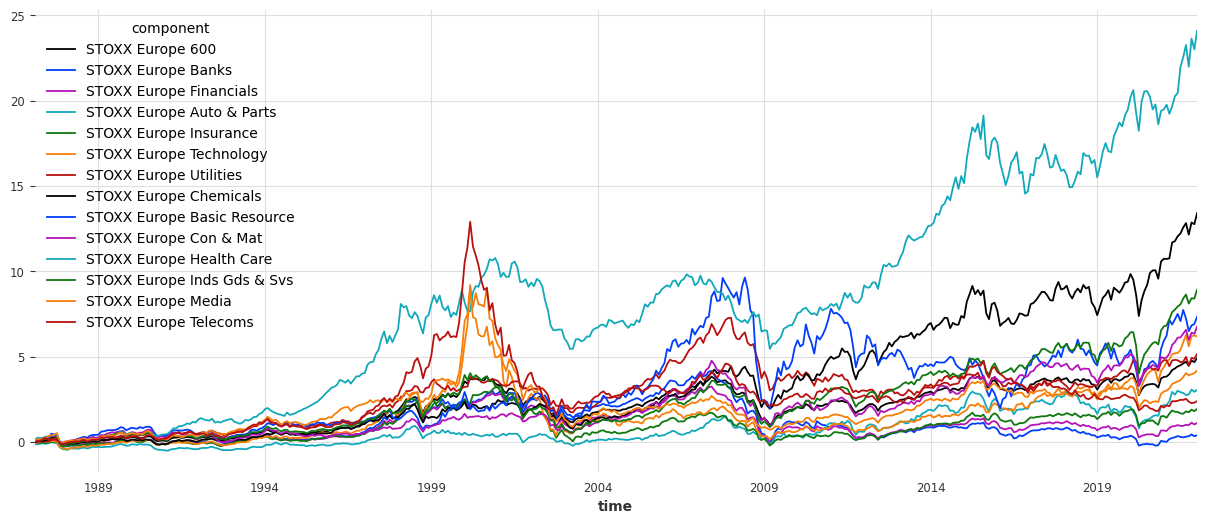

In [14]:
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

# plot the cumulative returns
cum_returns.plot(figsize=(15, 6));

In [18]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(cum_returns)

In [20]:
# show the average cumulative monthly return for all assets
average_returns = cum_returns.last_values().mean()
average_returns

6.4284077800970225

Nachdem wir nun die allgemeinen Basics gelegt haben, sprich, die kumulativen returns ermittelt  und das richtige Objekt-Format (Darts TimeSeries) implementiert haben, können wir im nächsten Schritt die zu replizierenden Modelle aufbauen.

Struktur:
1. Shrinkage Methods
2. Dimensionality reduction methods
3. Nonlinear ML methods
4. Combination ML models

Shrinkage methods:
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elastic Net
- Bridge Regression

Darts bietet wie erwähnt standardisierte Modelle an, in denen dann wie von mir verwendet, Sklearn-Methoden als Parameter eingebaut werden können.

Um die Modelle generell im ersten Schritt zu bauen, wurde kein tieferer Sinn bei den Parametern gedacht. Dies sollte im Hyperparamter Tuning für diese Daten erfolgen (dazu später mehr)

In [21]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

In [22]:
# linear regression model
linear_regression = LinearRegressionModel(lags=1, output_chunk_length=1)
linear_regression.fit(train)
linear_forecast = linear_regression.predict(len(test))

In [23]:
mean_return_lm = linear_forecast.last_values().mean()
mean_return_lm

6.552746050557699

In [24]:
# ridge regression model
ridge_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Ridge(alpha=1))
ridge_regression.fit(train)
ridge_forecast = ridge_regression.predict(len(test))

In [25]:
mean_return_rr = ridge_forecast.last_values().mean()
mean_return_rr

8.438291637542411

In [26]:
# lasso regression model
lasso_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Lasso(alpha=1))
lasso_regression.fit(train)
lasso_forecast = lasso_regression.predict(len(test))

In [27]:
mean_return_lr = lasso_forecast.last_values().mean()
mean_return_lr

2.082050266832744

In [28]:
# elastic net regression model
elastic_net_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.ElasticNet(alpha=1))
elastic_net_regression.fit(train)
elastic_net_forecast = elastic_net_regression.predict(len(test))

In [29]:
mean_return_el = elastic_net_forecast.last_values().mean()
mean_return_el

2.1234070573787713

In [31]:
# bridge regression model
bridge_regression = RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.LassoLarsCV(cv=3))
bridge_regression.fit(train)
bridge_forecast = bridge_regression.predict(len(test))

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkrus

In [32]:
mean_return_br = bridge_forecast.last_values().mean()
mean_return_br

5.117185043891381

Die Plots sind natürlich extrem unübersichtlich, da ich bisher alle gemessenen und vorhergesagten Werte für 14 Variablen plotte. Dies würde ich zu einem späteren Zeitpunkt übersichtlicher gestalten. (Mal abgesehen davon, dass Python mir hier nur 10 von 14 Variablen in die Plots einbezieht). Die Trends sind dennoch deutlich zu erkennen.

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

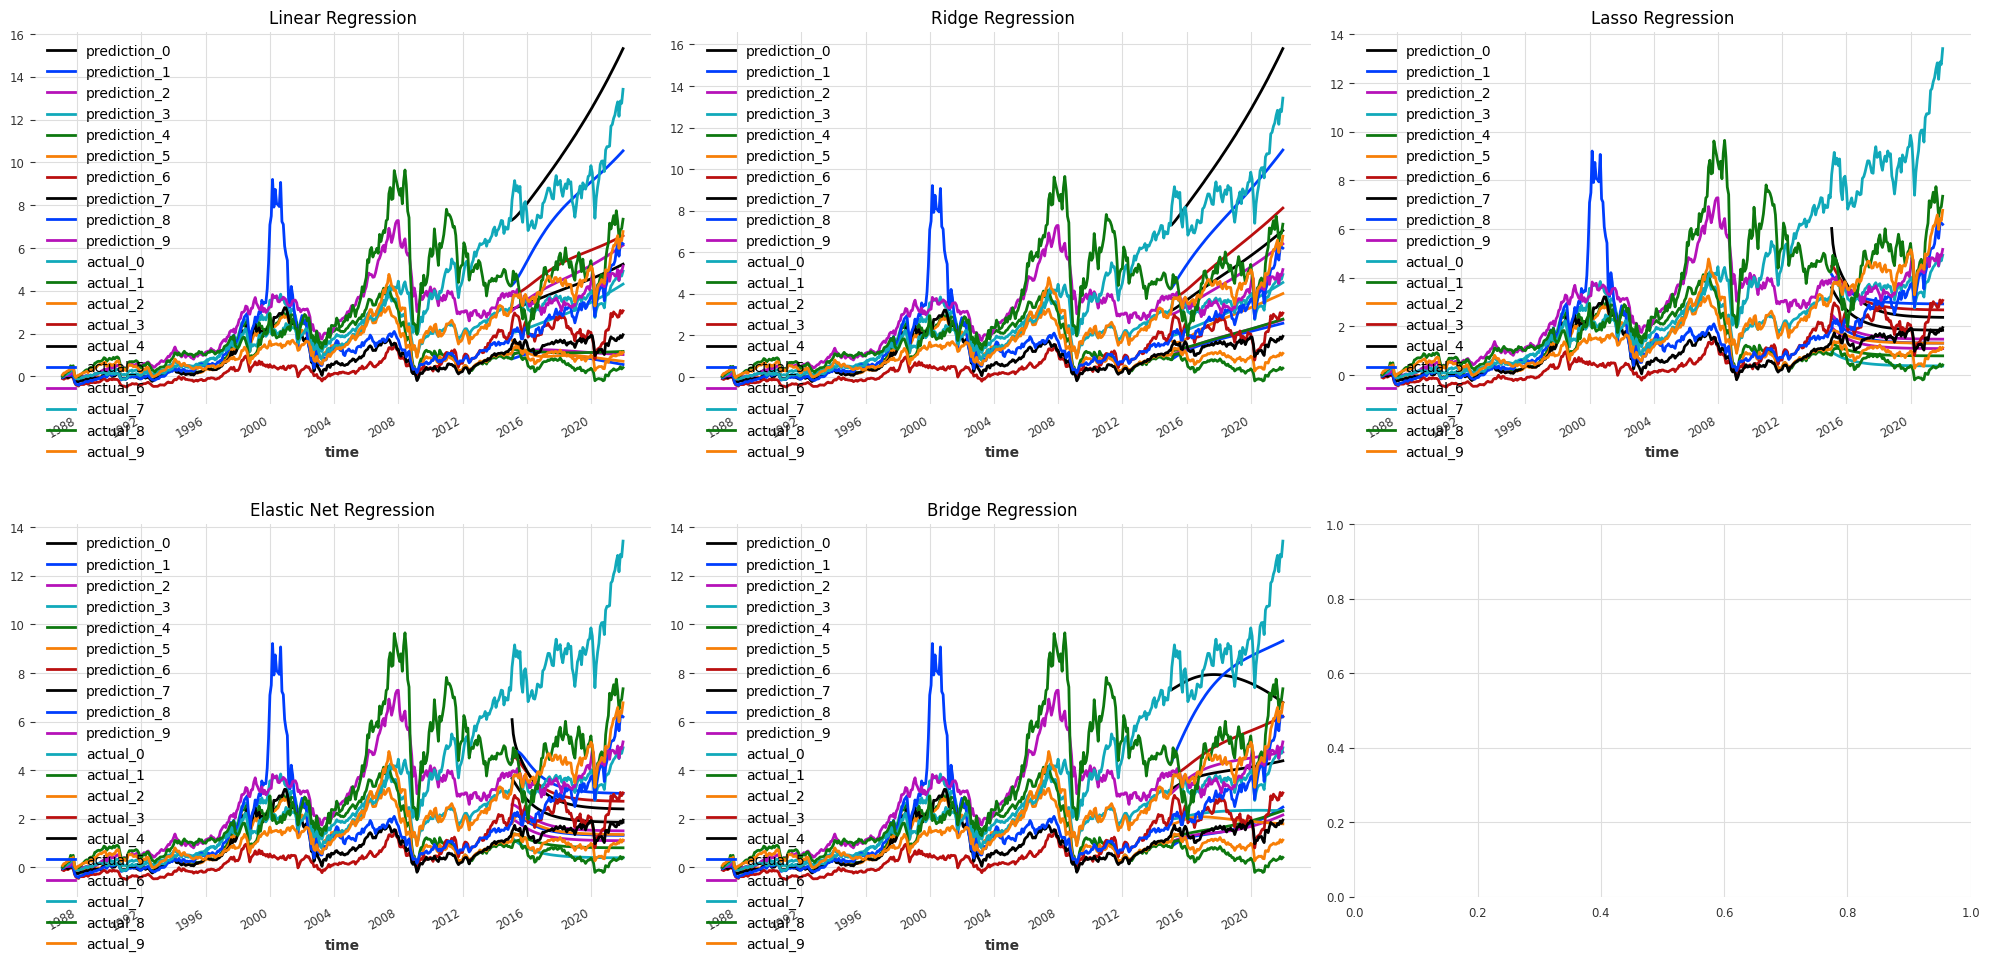

In [35]:
# Plot the predictions
shrinkage_forecasts = {'Linear Regression': linear_forecast,
                       'Ridge Regression': ridge_forecast,
                       'Lasso Regression': lasso_forecast,
                       'Elastic Net Regression': elastic_net_forecast,
                       'Bridge Regression': bridge_forecast}

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()

for i, (name, forecast) in enumerate(shrinkage_forecasts.items()):
    forecast.plot(label='prediction', ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)

plt.tight_layout();

Dimensionality reduction methods:
- PLS Regression
- PLS Canonical
- CCA

In [36]:
# pls regression model
pls_regression = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.PLSRegression(n_components=1))
pls_regression.fit(train)
pls_forecast = pls_regression.predict(len(test))

In [37]:
mean_return_pls = pls_forecast.last_values().mean()
mean_return_pls

3.49219137912649

In [38]:
# pls canonical regression model
pls_canonical = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.PLSCanonical(n_components=1))
pls_canonical.fit(train)
pls_canonical_forecast = pls_canonical.predict(len(test))

In [39]:
mean_return_can = pls_canonical_forecast.last_values().mean()
mean_return_can

4.871637099803123

In [40]:
# cca regression model
cca = RegressionModel(lags=1, output_chunk_length=1, model= sklearn.cross_decomposition.CCA(n_components=1))
cca.fit(train)
cca_forecast = cca.predict(len(test))

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [41]:
mean_return_cca = cca_forecast.last_values().mean()
mean_return_cca

4.541832920110343

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

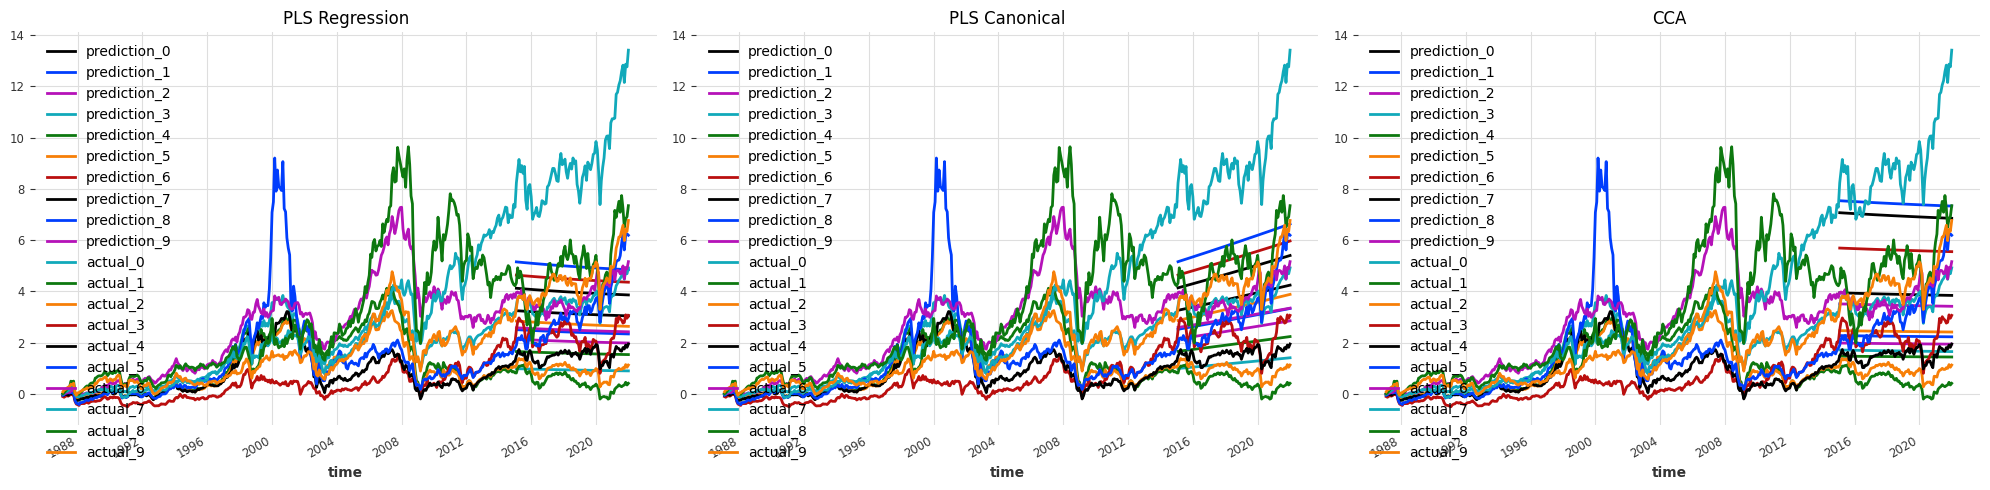

In [43]:
# Plot the predictions
dimensionality_forecasts = {'PLS Regression': pls_forecast,
                            'PLS Canonical': pls_canonical_forecast,
                            'CCA': cca_forecast}

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()

for i, (name, forecast) in enumerate(dimensionality_forecasts.items()):
    forecast.plot(label='prediction', ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)

plt.tight_layout();

Nonlinear ML methods
- Random Forest Regressor
- Gradient Boosting Regressor
- Ada Boost Regressor 
- ExtraTreesRegressor
- Support Vector Machine Regressor

In [44]:
# random forest model
random_forest = RandomForest(lags=100, output_chunk_length=1, n_estimators=100)
random_forest.fit(train)
random_forest_forecast = random_forest.predict(len(test))

In [45]:
mean_return_rf = random_forest_forecast.last_values().mean()
mean_return_rf

3.357679441028886

In [47]:
# gradient boosting model
gb_boosting = RegressionModel(lags=1, output_chunk_length=1, 
                              model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0))
gb_boosting.fit(train)
gb_boosting_forecast = gb_boosting.predict(len(test))

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkrus

In [48]:
mean_return_gb = gb_boosting_forecast.last_values().mean()
mean_return_gb

3.8297386225345957

In [49]:
# ada boosting model
ada_boosting = RegressionModel(lags=1, output_chunk_length=1,
                                 model=sklearn.ensemble.AdaBoostRegressor(n_estimators=100, random_state=0))
ada_boosting.fit(train)
ada_boosting_forecast = ada_boosting.predict(len(test))

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkrus

In [50]:
mean_return_adab = ada_boosting_forecast.last_values().mean()
mean_return_adab

3.8279205129433933

In [51]:
# extra tree regression model
extra_tree = RegressionModel(lags=1, output_chunk_length=1,
                                    model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0))
extra_tree.fit(train)
extra_tree_forecast = extra_tree.predict(len(test))

In [52]:
mean_return_et = extra_tree_forecast.last_values().mean()
mean_return_et

3.855870430456567

In [53]:
# support vector regression model
svr = RegressionModel(lags=1, output_chunk_length=1,
                                model=sklearn.svm.SVR(kernel='rbf', C=1e3, gamma=0.1))
svr.fit(train)
svr_forecast = svr.predict(len(test))

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkrus

In [54]:
mean_return_sv = svr_forecast.last_values().mean()
mean_return_sv

3.4855685767469686

Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 10 (14). Plotting only the first 10 components.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Number of components is larger than 

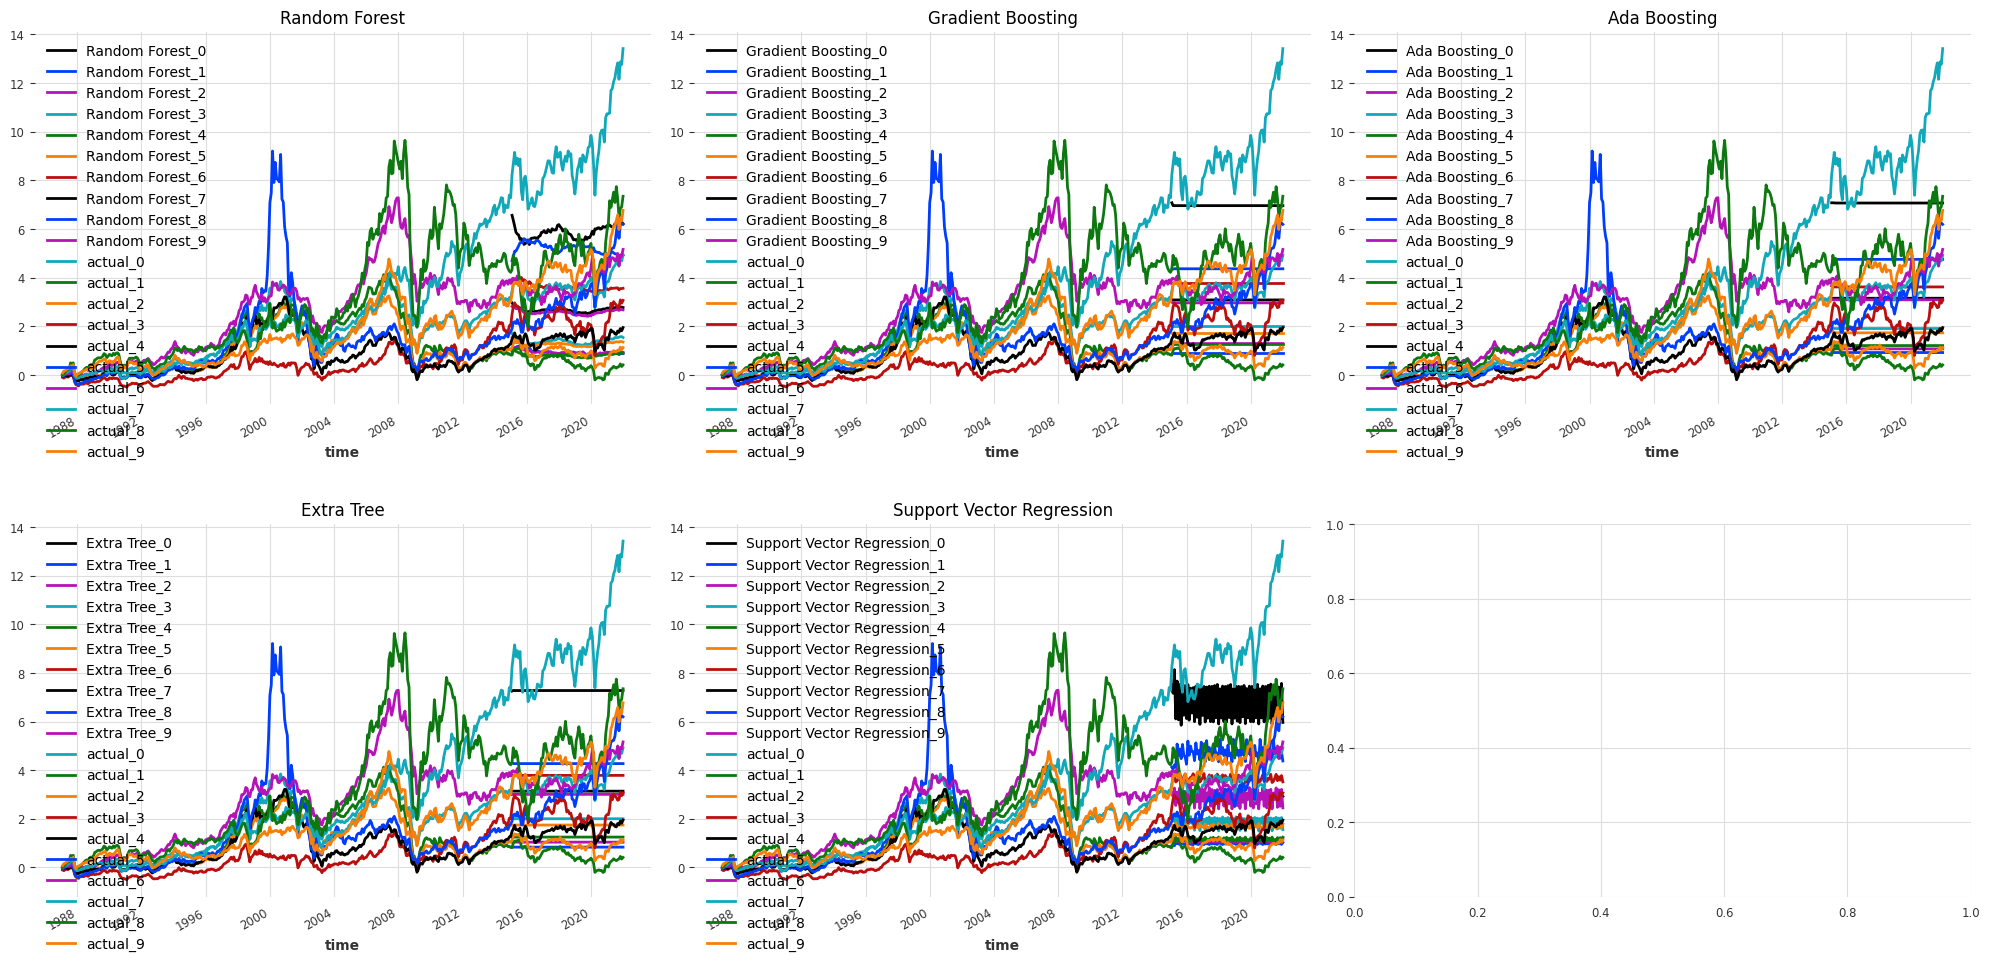

In [55]:
nonlinear_ML_forecasts = {'Random Forest': random_forest_forecast,
                          'Gradient Boosting': gb_boosting_forecast,
                          'Ada Boosting': ada_boosting_forecast,
                          'Extra Tree': extra_tree_forecast,
                          'Support Vector Regression': svr_forecast}

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()

for i, (name, forecast) in enumerate(nonlinear_ML_forecasts.items()):
    forecast.plot(label=name, ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)
    
plt.tight_layout();

Combination ML methods
- combination shrinkage
- combination dimensionality reduction
- combination nonlinear ML

In [56]:
# ensemble of regression models
shrinkage_ensemble = [LinearRegressionModel(lags=1, output_chunk_length=1),
                      RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Ridge(alpha=1)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.Lasso(alpha=1)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.ElasticNet(alpha=1)),
                       RegressionModel(lags=1, output_chunk_length=1, model=sklearn.linear_model.LassoLarsCV(cv=3))]

In [57]:
shrinkage_ensemble_model = RegressionEnsembleModel(forecasting_models=shrinkage_ensemble, regression_train_n_points=100)
shrinkage_ensemble_model.fit(train)
shrinkage_ensemble_forecast = shrinkage_ensemble_model.predict(len(test))

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkrus

In [58]:
# ensemble of dimsenionality reduction models
dim_ensemble = [RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.PLSRegression(n_components=1)),
                RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.PLSCanonical(n_components=1)),
                RegressionModel(lags=1, output_chunk_length=1, model=sklearn.cross_decomposition.CCA(n_components=1))]

In [59]:
dim_ensemble_model = RegressionEnsembleModel(forecasting_models=dim_ensemble, regression_train_n_points=100)
dim_ensemble_model.fit(train)
dim_ensemble_forecast = dim_ensemble_model.predict(len(test))

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [60]:
# ensemble of nonlinear models
nonlinear_ensemble = [RandomForest(lags=100, output_chunk_length=1, n_estimators=100),
                        RegressionModel(lags=100, output_chunk_length=1, model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.ensemble.AdaBoostRegressor(n_estimators=1000000, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)),
                        RegressionModel(lags=1, output_chunk_length=1, model=sklearn.svm.SVR(kernel='rbf', C=1e3, gamma=0.1))]

In [61]:
nonlinear_ensemble_model = RegressionEnsembleModel(forecasting_models=nonlinear_ensemble, regression_train_n_points=100)
nonlinear_ensemble_model.fit(train)
nonlinear_ensemble_forecast = nonlinear_ensemble_model.predict(len(test))

/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/antonkruse/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/antonkrus

In [ ]:
combination_forecasts = {'Shrinkage Combination': shrinkage_ensemble_forecast,
                         'Dimensionality Combination': dim_ensemble_forecast,
                         'Nonlinear Combination': nonlinear_ensemble_forecast}

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()

for i, (name, forecast) in enumerate(combination_forecasts.items()):
    forecast.plot(label=name, ax=ax[i])
    cum_returns.plot(label='actual', ax=ax[i])
    ax[i].legend()
    ax[i].set_title(name)
    
plt.tight_layout();

Nachdem sowohl die Mittelwerte der jeweiligen Portfolios im Vergleich zum Mittelwert der kumulativen Returns des Ursprungportfolios eher schlecht abgeschnitten haben, ist im folgenden Schritt das Hyperparameter Tuning logisch.

Hyperparameter Tuning ist ein Prozess (bzw. ein Optimierungsproblem), bei dem die Leistung eines maschinellen Lernmodells verbessert wird, indem verschiedene Kombinationen von Hyperparametern ausprobiert werden, um die besten Einstellungen für das Modell zu finden.

Darts bietet hierfür die .gridsearch() Funktion an. Diese habe ich anhand der Linearen und Ridge Regressionen getestet (wobei alpha der Ridge Regression noch außen vor war) und die Parameter Ergebnisse mittels des MAPE gegen die bisherigen Versionen getestet.

Nach meinem Verständnis wird der MAPE verwendet um die Performance eines Forecasting Models zu evaluieren. Er wird in Prozent ausgedrückt und gibt an, wie stark die Vorhersagen des Modells im Durchschnitt von den tatsächlichen Werten abweichen. Je niedriger der MAPE-Wert ist, desto besser ist die Leistung des Modells.

In [63]:
# test hyperparameter tuning linear regression model
lm_parameters = {
    'lags': [1, 2, 3, 4, 5],
    'output_chunk_length': [1, 2, 3, 4, 5]
}

result = linear_regression.gridsearch(parameters=lm_parameters, series=cum_returns, forecast_horizon=5)
best_model = result[1]
best_parameters = result[2]
print('Best model: ', best_model, ' with parameters: ', best_parameters)

Best model:  {'lags': 1, 'output_chunk_length': 1}  with parameters:  24.116995980889328


In [64]:
# since the best model is the same as the default model, we can use the default model
lm_score = mape(cum_returns, linear_forecast)
print('MAPE of linear model: ', lm_score)

MAPE of linear model:  45.69106381449611


Dieser MAPE Wert erscheint mir ausgesprochen hoch!

Interpretation/Erklärung folgt!!

Lösung finden für alpha tuning.